# 08/06/2024
Fiona Zheng

In [637]:
import pandas as pd
import numpy as np
import holidays
import warnings
warnings.filterwarnings('ignore')

# check sumup

In [638]:
historical_df = pd.read_excel(r'data\United Historical Hourly Load-2013-2022.xlsx')
historical_df.drop(columns = ['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'], inplace = True)
historical_df

,Year,MONTH,DAY,TIME,Load,MW
0,2013,1,1,01:00:00,158438.0,158.438
1,2013,1,1,02:00:00,152643.0,152.643
2,2013,1,1,03:00:00,149105.0,149.105
3,2013,1,1,04:00:00,147235.0,147.235
4,2013,1,1,05:00:00,146788.0,146.788
...,...,...,...,...,...,...
87642,2022,12,31,19:00:00,413063.0,413.063
87643,2022,12,31,20:00:00,404533.0,404.533
87644,2022,12,31,21:00:00,395172.0,395.172
87645,2022,12,31,22:00:00,387412.0,387.412


In [639]:
# sum up the MW values for each year
yearly_sum = historical_df.groupby('Year')['MW'].sum().reset_index()
# Display the result
yearly_sum.rename(columns = {'MW':'value calculated'}, inplace = True)

In [640]:
real_df = {
    "year": [2018, 2019, 2020, 2021, 2022],
    "united_report": [2447189, 2739378, 2871674, 2902460, 2993636],
}
real_df = pd.DataFrame.from_dict(real_df)
# combine the yearly_sum to real_df
real_df = pd.merge(real_df, yearly_sum, how='left', left_on='year', right_on = 'Year')
real_df.drop(columns=['Year'], inplace=True)

In [641]:
real_df['ratio'] = real_df['united_report'] / real_df['value calculated']

In [642]:
real_df

,year,united_report,value calculated,ratio
0,2018,2447189,2.517293e+06,0.972151
1,2019,2739378,3.553970e+06,0.770794
2,2020,2871674,3.818834e+06,0.751977
3,2021,2902460,3.644419e+06,0.796412
4,2022,2993636,3.104588e+06,0.964262


# 1. average model
## 1.1. load data

In [749]:
df = pd.read_excel(r'data\United Historical Hourly Load-2013-2022.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87647 entries, 0 to 87646
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         87647 non-null  int64  
 1   MONTH        87647 non-null  int64  
 2   DAY          87647 non-null  int64  
 3   TIME         87647 non-null  object 
 4   Load         87647 non-null  float64
 5   MW           87647 non-null  float64
 6   Unnamed: 6   0 non-null      float64
 7   Unnamed: 7   0 non-null      float64
 8   Unnamed: 8   4 non-null      object 
 9   Unnamed: 9   13 non-null     object 
 10  Unnamed: 10  12 non-null     object 
dtypes: float64(4), int64(3), object(4)
memory usage: 7.4+ MB


In [750]:
df.drop(columns = ['Load', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'], inplace=True)
df.rename(columns = {'Year': 'year', 'MONTH': 'month', 'DAY': 'day', 'TIME':'time', 'MW':'gross_load'}, inplace=True)

In [751]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87647 entries, 0 to 87646
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        87647 non-null  int64  
 1   month       87647 non-null  int64  
 2   day         87647 non-null  int64  
 3   time        87647 non-null  object 
 4   gross_load  87647 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.3+ MB


In [754]:
df['time'] = df['time'].replace('1900-01-01 00:00:00', '12:00:00')

In [755]:
# Create a datetime column by combining year, month, day, and time
df['hour_begins'] = pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
df['hour_begins'] = df['hour_begins'].astype(str)
df['time'] = df['time'].astype(str)
df['hour_begins'] = df['hour_begins']+ ' ' + df['time']
df['hour_begins'] = pd.to_datetime(df['hour_begins'], format='%Y-%m-%d %H:%M:%S')

In [756]:
df

,year,month,day,time,gross_load,hour_begins
0,2013,1,1,01:00:00,158.438,2013-01-01 01:00:00
1,2013,1,1,02:00:00,152.643,2013-01-01 02:00:00
2,2013,1,1,03:00:00,149.105,2013-01-01 03:00:00
3,2013,1,1,04:00:00,147.235,2013-01-01 04:00:00
4,2013,1,1,05:00:00,146.788,2013-01-01 05:00:00
...,...,...,...,...,...,...
87642,2022,12,31,19:00:00,413.063,2022-12-31 19:00:00
87643,2022,12,31,20:00:00,404.533,2022-12-31 20:00:00
87644,2022,12,31,21:00:00,395.172,2022-12-31 21:00:00
87645,2022,12,31,22:00:00,387.412,2022-12-31 22:00:00


In [757]:
# add a column named ratio from real_df, group by Year
df = df.merge(real_df[['year', 'ratio']], on='year', how='left')
# if ratio is not na, then gross_load * ratio
df['gross_load'] = np.where(df['ratio'].notna(), df['gross_load'] * df['ratio'], df['gross_load'])
df

,year,month,day,time,gross_load,hour_begins,ratio
0,2013,1,1,01:00:00,158.438000,2013-01-01 01:00:00,NaN
1,2013,1,1,02:00:00,152.643000,2013-01-01 02:00:00,NaN
2,2013,1,1,03:00:00,149.105000,2013-01-01 03:00:00,NaN
3,2013,1,1,04:00:00,147.235000,2013-01-01 04:00:00,NaN
4,2013,1,1,05:00:00,146.788000,2013-01-01 05:00:00,NaN
...,...,...,...,...,...,...,...
87642,2022,12,31,19:00:00,398.300968,2022-12-31 19:00:00,0.964262
87643,2022,12,31,20:00:00,390.075813,2022-12-31 20:00:00,0.964262
87644,2022,12,31,21:00:00,381.049356,2022-12-31 21:00:00,0.964262
87645,2022,12,31,22:00:00,373.566682,2022-12-31 22:00:00,0.964262


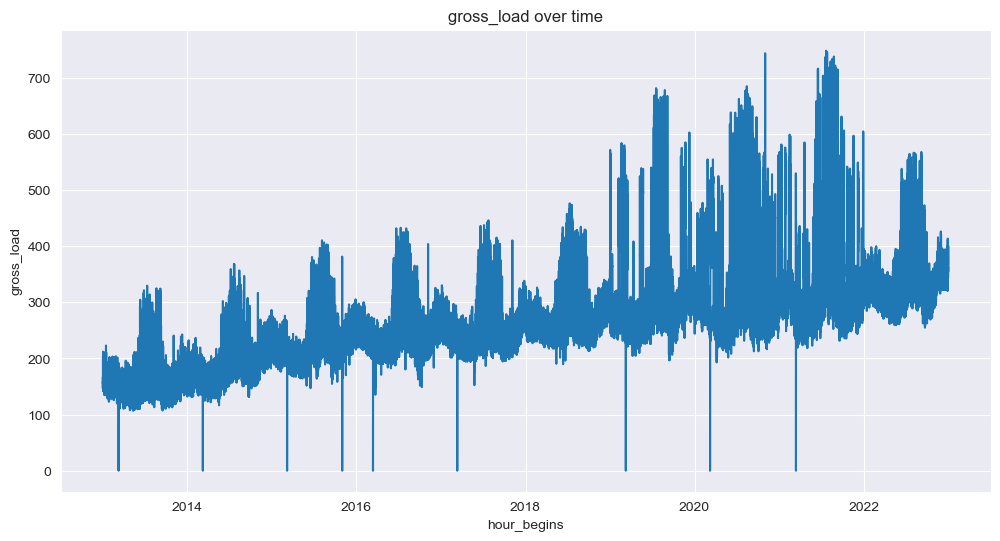

In [758]:
import matplotlib.pyplot as plt

# basic plots for actual_gross_load with x being hour_begins
plt.figure(figsize=(12, 6))
plt.plot(df['hour_begins'], df['gross_load'])
plt.title('gross_load over time')
plt.xlabel('hour_begins')
plt.ylabel('gross_load')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of outliers: 1754


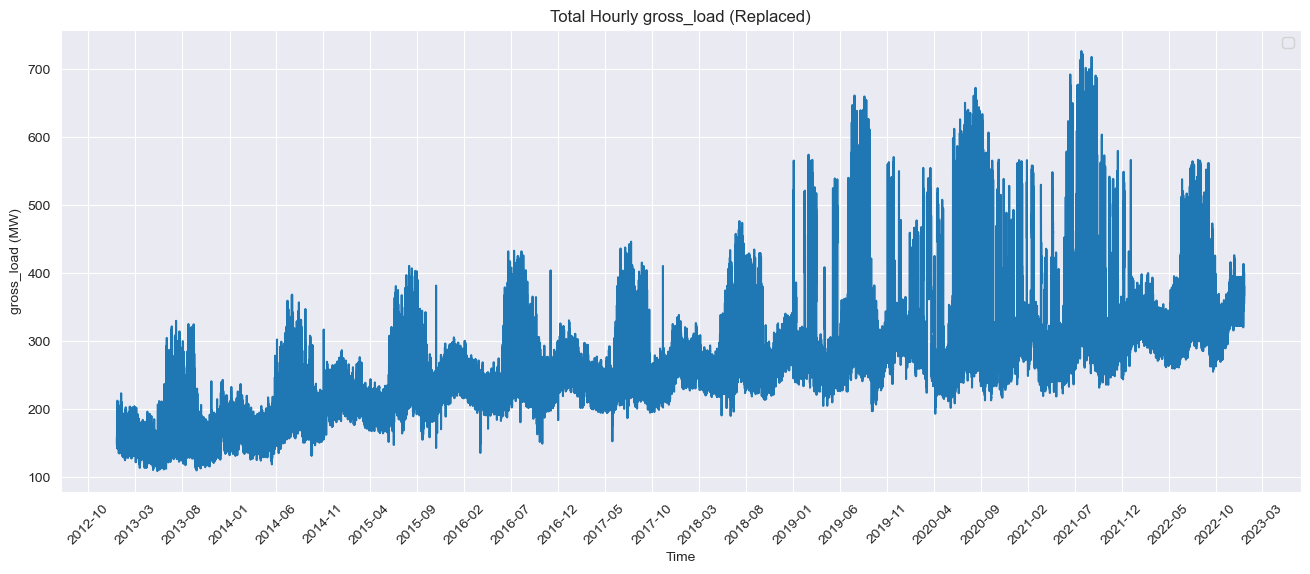

In [759]:
# replace the outlier values as the average of the previous day and the next day
def replace_outliers_with_avg(s):
    lower_bound = s.quantile(0.01)
    upper_bound = s.quantile(0.99)
    outliers = (s < lower_bound) | (s > upper_bound)
    
    for idx in s[outliers].index:
        if idx == 0 or idx == len(s) - 1:
            # directly drop the first and last value
            s.at[idx] = np.nan
            continue
        prev_val = s.iloc[idx - 1]
        next_val = s.iloc[idx + 1]
        s.at[idx] = (prev_val + next_val) / 2
    return s

# reset index 
df.reset_index(drop=True, inplace=True)
# Assuming df is your DataFrame and 'hour_begins' and 'gross_load' are the relevant columns
df['gross_load_replaced'] = replace_outliers_with_avg(df['gross_load'].copy())

# Number of outliers
print(f'Number of outliers: {df[df["gross_load"] != df["gross_load_replaced"]].shape[0]}')

# Plot the replaced 'gross_load_replaced'
plt.figure(figsize=(16, 6))
plt.plot(df['hour_begins'], df['gross_load_replaced'])
plt.xlabel('Time')
plt.ylabel('gross_load (MW)')
plt.title('Total Hourly gross_load (Replaced)')
plt.legend()
# Set date format on x-axis every 5 month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()


## 1.1.feature engineering

In [782]:
# calculate the daily average load
df['date'] = df['hour_begins'].dt.date
daily_gross_load = df.groupby('date')['gross_load_replaced'].mean().reset_index()
daily_high = df.groupby('date')['gross_load_replaced'].max().reset_index()
daily_low = df.groupby('date')['gross_load_replaced'].min().reset_index()
daily_std = df.groupby('date')['gross_load_replaced'].std().reset_index()

daily_gross_load['daily_high'] = daily_high['gross_load_replaced']
daily_gross_load['daily_low'] = daily_low['gross_load_replaced']
daily_gross_load['daily_std'] = daily_std['gross_load_replaced']
daily_gross_load.rename(columns = {'gross_load_replaced': 'daily_avg'}, inplace = True)

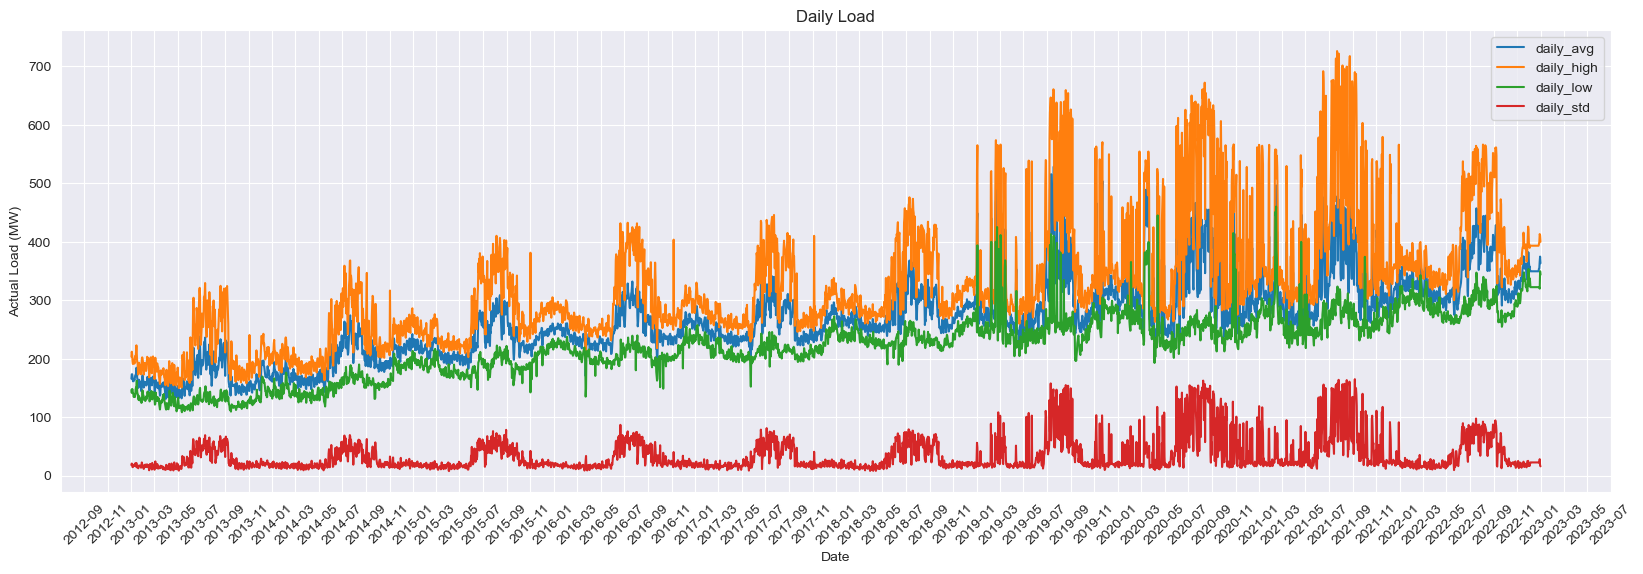

In [783]:
import matplotlib.dates as mdates
# plot the daily average, min, max, std
plt.figure(figsize=(20, 6))
plt.plot(daily_gross_load['date'], daily_gross_load['daily_avg'], label='daily_avg')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_high'], label='daily_high')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_low'], label='daily_low')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_std'], label='daily_std')
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.title('Daily Load')
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # set to show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

In [784]:
daily_gross_load

,date,daily_avg,daily_high,daily_low,daily_std
0,2013-01-01,165.979000,203.600000,146.788000,18.216305
1,2013-01-02,173.348625,212.060000,141.787000,20.874815
2,2013-01-03,173.640167,207.349000,148.370000,17.826087
3,2013-01-04,169.001958,195.401000,147.485000,14.669821
4,2013-01-05,161.574333,191.075000,141.080000,14.906045
...,...,...,...,...,...
3647,2022-12-27,353.843667,395.924062,322.467544,22.160148
3648,2022-12-28,354.626768,399.978784,322.129088,22.549657
3649,2022-12-29,366.429737,413.193995,319.972999,28.309180
3650,2022-12-30,374.711221,410.782375,349.678055,17.497577


In [785]:
# day of the week, month, year, season vairables
daily_gross_load['date'] = pd.to_datetime(daily_gross_load['date'])
daily_gross_load['day_of_week'] = daily_gross_load['date'].dt.dayofweek
daily_gross_load['month'] = daily_gross_load['date'].dt.month
daily_gross_load['year'] = daily_gross_load['date'].dt.year
daily_gross_load['seasons'] = (daily_gross_load['month']%12 + 3)//3
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
daily_gross_load['seasons'] = daily_gross_load['seasons'].map(seasons)

In [786]:
daily_gross_load['month_sin'] = np.sin((daily_gross_load['month'] - 1) * (2. * np.pi / 12))
daily_gross_load['month_cos'] = np.cos((daily_gross_load['month'] - 1) * (2. * np.pi / 12))
daily_gross_load['dow_sin'] = np.sin(daily_gross_load['day_of_week'] * (2. * np.pi / 7))
daily_gross_load['dow_cos'] = np.cos(daily_gross_load['day_of_week'] * (2. * np.pi / 7))

In [787]:
# holiday - 0/1 binary
us_holidays = holidays.US()
daily_gross_load['holiday'] = daily_gross_load['date'].apply(lambda x: 1 if x in us_holidays else 0)

In [788]:
daily_gross_load.drop(columns=['daily_high','daily_low', 'daily_std'], inplace=True)
daily_gross_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3652 non-null   datetime64[ns]
 1   daily_avg    3652 non-null   float64       
 2   day_of_week  3652 non-null   int32         
 3   month        3652 non-null   int32         
 4   year         3652 non-null   int32         
 5   seasons      3652 non-null   object        
 6   month_sin    3652 non-null   float64       
 7   month_cos    3652 non-null   float64       
 8   dow_sin      3652 non-null   float64       
 9   dow_cos      3652 non-null   float64       
 10  holiday      3652 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int32(3), int64(1), object(1)
memory usage: 271.2+ KB


In [789]:
# print out the numerical and categorical features
numerical_features = daily_gross_load.select_dtypes(include=['float64']).columns.tolist()
categorical_features = daily_gross_load.select_dtypes(include=['datetime64[ns]', 'object', 'bool','int32','int64']).columns.tolist()
target = 'daily_avg'
numerical_features.remove(target)
print(f'Target variable: {target}')
print(f'Numerical features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

# put categorical features first, numerical features last
daily_gross_load = daily_gross_load[categorical_features + numerical_features + [target]]
daily_gross_load

Target variable: daily_avg
Numerical features: ['month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Categorical features: ['date', 'day_of_week', 'month', 'year', 'seasons', 'holiday']


,date,day_of_week,month,year,seasons,holiday,month_sin,month_cos,dow_sin,dow_cos,daily_avg
0,2013-01-01,1,1,2013,Winter,1,0.0,1.000000,0.781831,0.623490,165.979000
1,2013-01-02,2,1,2013,Winter,0,0.0,1.000000,0.974928,-0.222521,173.348625
2,2013-01-03,3,1,2013,Winter,0,0.0,1.000000,0.433884,-0.900969,173.640167
3,2013-01-04,4,1,2013,Winter,0,0.0,1.000000,-0.433884,-0.900969,169.001958
4,2013-01-05,5,1,2013,Winter,0,0.0,1.000000,-0.974928,-0.222521,161.574333
...,...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-27,1,12,2022,Winter,0,-0.5,0.866025,0.781831,0.623490,353.843667
3648,2022-12-28,2,12,2022,Winter,0,-0.5,0.866025,0.974928,-0.222521,354.626768
3649,2022-12-29,3,12,2022,Winter,0,-0.5,0.866025,0.433884,-0.900969,366.429737
3650,2022-12-30,4,12,2022,Winter,0,-0.5,0.866025,-0.433884,-0.900969,374.711221


In [790]:
daily_gross_load.columns

Index(['date', 'day_of_week', 'month', 'year', 'seasons', 'holiday',
       'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'daily_avg'],
      dtype='object')

##  1.2. scaling and encoding

In [791]:
# encoding the categorical features - season only at the second column of values
daily_gross_load = pd.get_dummies(daily_gross_load, columns=['seasons'], drop_first=True) # at the last 3 columns
# Convert boolean columns to integers
for col in daily_gross_load.columns:
    if daily_gross_load[col].dtype == 'bool':
        daily_gross_load[col] = daily_gross_load[col].astype(int)
# place the target variable at the last column
daily_gross_load = daily_gross_load[[c for c in daily_gross_load if c not in ['daily_avg']] + ['daily_avg']]

In [792]:
daily_gross_load

,date,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_avg
0,2013-01-01,1,1,2013,1,0.0,1.000000,0.781831,0.623490,0,0,1,165.979000
1,2013-01-02,2,1,2013,0,0.0,1.000000,0.974928,-0.222521,0,0,1,173.348625
2,2013-01-03,3,1,2013,0,0.0,1.000000,0.433884,-0.900969,0,0,1,173.640167
3,2013-01-04,4,1,2013,0,0.0,1.000000,-0.433884,-0.900969,0,0,1,169.001958
4,2013-01-05,5,1,2013,0,0.0,1.000000,-0.974928,-0.222521,0,0,1,161.574333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-27,1,12,2022,0,-0.5,0.866025,0.781831,0.623490,0,0,1,353.843667
3648,2022-12-28,2,12,2022,0,-0.5,0.866025,0.974928,-0.222521,0,0,1,354.626768
3649,2022-12-29,3,12,2022,0,-0.5,0.866025,0.433884,-0.900969,0,0,1,366.429737
3650,2022-12-30,4,12,2022,0,-0.5,0.866025,-0.433884,-0.900969,0,0,1,374.711221


In [793]:
# scaling the columns except for the 1 column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_gross_load.iloc[:, 1:] = scaler.fit_transform(daily_gross_load.iloc[:, 1:])
daily_gross_load

,date,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_avg
0,2013-01-01,0.166667,0.0,0.0,1,0.50,1.000000,0.900969,8.019377e-01,0,0,1,0.087053
1,2013-01-02,0.333333,0.0,0.0,0,0.50,1.000000,1.000000,3.568959e-01,0,0,1,0.105597
2,2013-01-03,0.500000,0.0,0.0,0,0.50,1.000000,0.722521,5.551115e-17,0,0,1,0.106331
3,2013-01-04,0.666667,0.0,0.0,0,0.50,1.000000,0.277479,0.000000e+00,0,0,1,0.094659
4,2013-01-05,0.833333,0.0,0.0,0,0.50,1.000000,0.000000,3.568959e-01,0,0,1,0.075969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-27,0.166667,1.0,1.0,0,0.25,0.933013,0.900969,8.019377e-01,0,0,1,0.559781
3648,2022-12-28,0.333333,1.0,1.0,0,0.25,0.933013,1.000000,3.568959e-01,0,0,1,0.561752
3649,2022-12-29,0.500000,1.0,1.0,0,0.25,0.933013,0.722521,5.551115e-17,0,0,1,0.591452
3650,2022-12-30,0.666667,1.0,1.0,0,0.25,0.933013,0.277479,0.000000e+00,0,0,1,0.612291


In [794]:
# save the values of column gross_load_replaced, drop it and the attach at the last column 
gross_load_replaced = daily_gross_load['daily_avg']
daily_gross_load.drop(columns='daily_avg', inplace=True)
daily_gross_load['daily_avg'] = gross_load_replaced
daily_gross_load

,date,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_avg
0,2013-01-01,0.166667,0.0,0.0,1,0.50,1.000000,0.900969,8.019377e-01,0,0,1,0.087053
1,2013-01-02,0.333333,0.0,0.0,0,0.50,1.000000,1.000000,3.568959e-01,0,0,1,0.105597
2,2013-01-03,0.500000,0.0,0.0,0,0.50,1.000000,0.722521,5.551115e-17,0,0,1,0.106331
3,2013-01-04,0.666667,0.0,0.0,0,0.50,1.000000,0.277479,0.000000e+00,0,0,1,0.094659
4,2013-01-05,0.833333,0.0,0.0,0,0.50,1.000000,0.000000,3.568959e-01,0,0,1,0.075969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-27,0.166667,1.0,1.0,0,0.25,0.933013,0.900969,8.019377e-01,0,0,1,0.559781
3648,2022-12-28,0.333333,1.0,1.0,0,0.25,0.933013,1.000000,3.568959e-01,0,0,1,0.561752
3649,2022-12-29,0.500000,1.0,1.0,0,0.25,0.933013,0.722521,5.551115e-17,0,0,1,0.591452
3650,2022-12-30,0.666667,1.0,1.0,0,0.25,0.933013,0.277479,0.000000e+00,0,0,1,0.612291


In [795]:
daily_gross_load = daily_gross_load.dropna()
daily_gross_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            3652 non-null   datetime64[ns]
 1   day_of_week     3652 non-null   float64       
 2   month           3652 non-null   float64       
 3   year            3652 non-null   float64       
 4   holiday         3652 non-null   int64         
 5   month_sin       3652 non-null   float64       
 6   month_cos       3652 non-null   float64       
 7   dow_sin         3652 non-null   float64       
 8   dow_cos         3652 non-null   float64       
 9   seasons_Spring  3652 non-null   int32         
 10  seasons_Summer  3652 non-null   int32         
 11  seasons_Winter  3652 non-null   int32         
 12  daily_avg       3652 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int32(3), int64(1)
memory usage: 328.2 KB


## 1.3. dividing the data into training and testing

In [796]:
years_of_data = len(daily_gross_load) / 365
print(f'Total years of data: {years_of_data}')
# total number of days for training and testing
print(f'Total number of days for training: {daily_gross_load.shape[0]}')

Total years of data: 10.005479452054795
Total number of days for training: 3652


In [797]:
daily_gross_load = daily_gross_load.sort_values(by='date')
values = daily_gross_load.drop(columns='date').values
dates = daily_gross_load['date']

# out of sample data: total length multiplies 0.3
train_days = int(values.shape[0] * 0.7)
# in sample data: the rest of the data
train = values[:train_days, :]
train_timestamps = dates[:train_days]
# print(f'start date of in sample data: {train["date"].min()}')
# print(f'end date of in sample data: {train["date"].max()}')
# print(f'length of in sample data: {train.
# shape[0]}\n')

print(f'min: {train_timestamps.min()}')
print(f'max: {train_timestamps.max()}')
print(f'length of in sample data: {train.shape[0]}\n')

test = values[train_days:, : ]
test_timestamps = dates[train_days:]
# print(f'start date of out of sample data: {test["date"].min()}')
# print(f'end date of out of sample data: {test["date"].max()}')
# print(f'length of out of sample data: {test.shape[0]}\n')

print(f'min: {test_timestamps.min()}')
print(f'max: {test_timestamps.max()}')
print(f'length of out of sample data: {test.shape[0]}')

min: 2013-01-01 00:00:00
max: 2019-12-31 00:00:00
length of in sample data: 2556

min: 2020-01-01 00:00:00
max: 2022-12-31 00:00:00
length of out of sample data: 1096


In [798]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2556, 1, 11) (2556,) (1096, 1, 11) (1096,)


## 1.4. fitting the model

In [815]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
# design network

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_regularizer=l2(0.001)))

# Set the initial learning rate to a lower value
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6)

# Fit the network
history = model.fit(train_X, train_y, epochs=200, batch_size=80, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

Epoch 1/200
32/32 - 1s - 42ms/step - loss: 0.3409 - mae: 0.3391 - mape: 28091.8867 - mse: 0.1370 - val_loss: 0.5559 - val_mae: 0.5541 - val_mape: 110.7136 - val_mse: 0.3256 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 - 0s - 2ms/step - loss: 0.3040 - mae: 0.3022 - mape: 47933.9922 - mse: 0.1124 - val_loss: 0.5144 - val_mae: 0.5126 - val_mape: 101.8884 - val_mse: 0.2813 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 - 0s - 1ms/step - loss: 0.2677 - mae: 0.2659 - mape: 26439.6836 - mse: 0.0912 - val_loss: 0.4736 - val_mae: 0.4718 - val_mape: 93.2161 - val_mse: 0.2410 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 - 0s - 1ms/step - loss: 0.2338 - mae: 0.2320 - mape: 2132.5608 - mse: 0.0725 - val_loss: 0.4337 - val_mae: 0.4319 - val_mape: 84.7270 - val_mse: 0.2049 - learning_rate: 1.0000e-04
Epoch 5/200
32/32 - 0s - 1ms/step - loss: 0.2037 - mae: 0.2019 - mape: 51003.6016 - mse: 0.0581 - val_loss: 0.3953 - val_mae: 0.3935 - val_mape: 76.5468 - val_mse: 0.1731 - learning_rate: 1.0000e-04
Epo

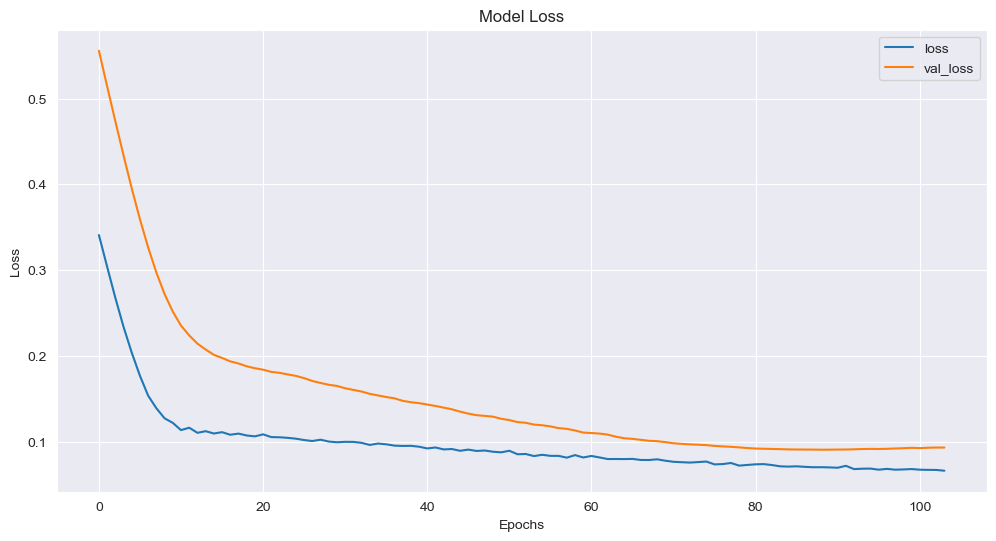

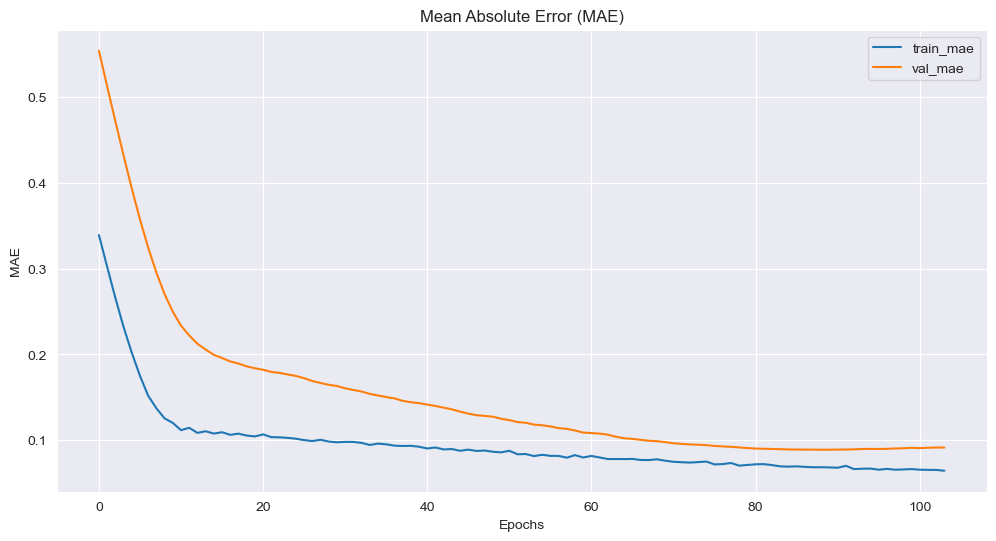

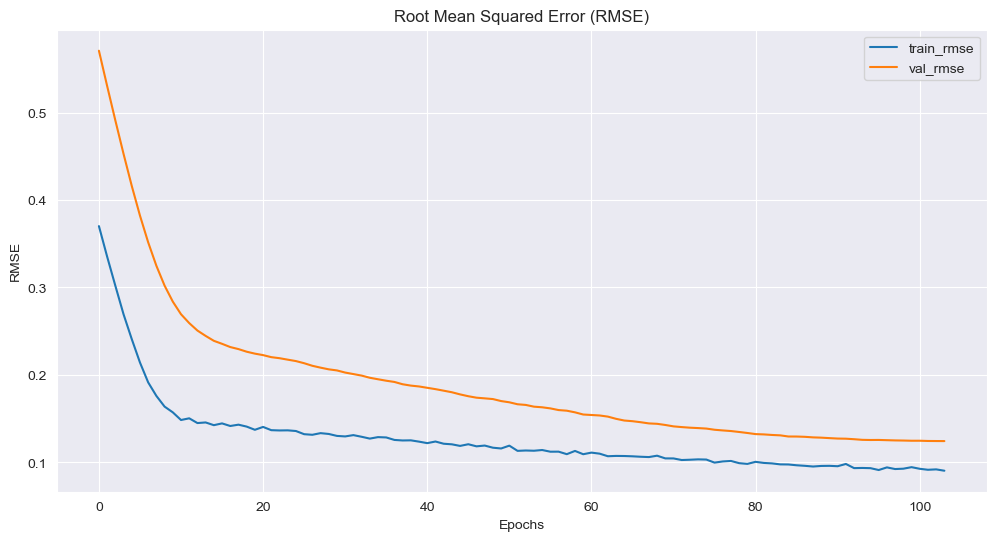

In [816]:
# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [817]:
# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((train_X_reshaped,train_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
train_y_reshaped = train_y.reshape((len(train_y), 1))
inv_y = np.concatenate((train_X_reshaped, train_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
train_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
train_mae = mean_absolute_error(inv_y, inv_yhat)
train_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


test_predictions = model.predict(test_X)
# Reshape test_X for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((test_X_reshaped,test_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X_reshaped, test_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
test_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
test_mae = mean_absolute_error(inv_y, inv_yhat)
test_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Train MAPE: {train_mape:.3f}%")
print(f"\nTest RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test MAPE: {test_mape:.3f}%")

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
Train RMSE: 31.567
Train MAE: 20.552
Train MAPE: 8.461%

Test RMSE: 50.994
Test MAE: 35.287
Test MAPE: 9.831%


## 1.5. prediction plot

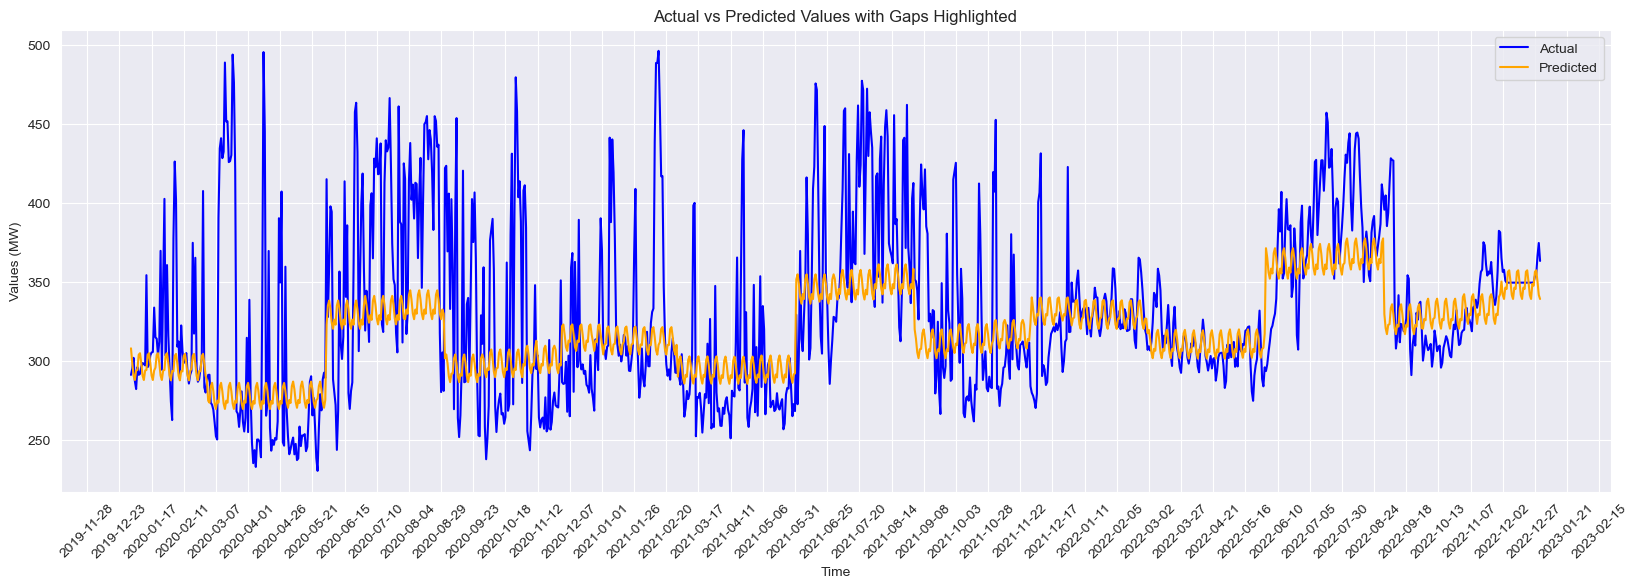

Gaps in data:


In [818]:
# Extract the test data with timestamps
test_df = daily_gross_load.iloc[train_days:, :].copy()
test_df['date'] = daily_gross_load.iloc[train_days:]['date']

# Identify gaps in the data
actual_vs_predicted = pd.DataFrame({
    'date': test_timestamps,
    'actual': inv_y,
    'predicted': inv_yhat
})

# Check for gaps in the timestamps (in days)
actual_vs_predicted['date_diff'] = actual_vs_predicted['date'].diff().dt.days
gaps = actual_vs_predicted[actual_vs_predicted['date_diff'] > 1]

# Plot actual vs predicted values with gaps highlighted
plt.figure(figsize=(20, 6))
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['actual'], label='Actual', color='blue')
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['predicted'], label='Predicted', color='orange')
for gap_start in gaps['date']:
    plt.axvline(x=gap_start, color='red', linestyle='--', alpha=0.5)
plt.title('Actual vs Predicted Values with Gaps Highlighted')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)

# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()

# Print the gaps and their nearest significant time differences
print("Gaps in data:")
for index, row in gaps.iterrows():
    previous_timestamp = row['date'] - pd.Timedelta(days=row['date_diff'])
    next_timestamp = row['date'] + pd.Timedelta(days=row['date_diff'])

    previous_row = actual_vs_predicted[actual_vs_predicted['date'] == previous_timestamp]
    next_row = actual_vs_predicted[actual_vs_predicted['date'] == next_timestamp]

    gap_start = previous_row['date'].values[0] if not previous_row.empty else 'N/A'
    gap_end = row['date']

    print(f"Gap Start: {pd.to_datetime(gap_start).strftime('%Y-%m-%d') if gap_start != 'N/A' else 'N/A'}")
    print(f"Gap ends at: {gap_end.strftime('%Y-%m-%d')}")
    print(f"Time Difference: {row['date_diff']} days\n")

# 2. sumup model

## 2.1. load data

In [566]:
df = pd.read_excel(r'data\United Historical Hourly Load-2013-2022.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87647 entries, 0 to 87646
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         87647 non-null  int64  
 1   MONTH        87647 non-null  int64  
 2   DAY          87647 non-null  int64  
 3   TIME         87647 non-null  object 
 4   Load         87647 non-null  float64
 5   MW           87647 non-null  float64
 6   Unnamed: 6   0 non-null      float64
 7   Unnamed: 7   0 non-null      float64
 8   Unnamed: 8   4 non-null      object 
 9   Unnamed: 9   13 non-null     object 
 10  Unnamed: 10  12 non-null     object 
dtypes: float64(4), int64(3), object(4)
memory usage: 7.4+ MB


In [567]:
df.columns

Index(['Year', 'MONTH', 'DAY', 'TIME', 'Load', 'MW', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'],
      dtype='object')

In [568]:
df.drop(columns = ['Load', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'], inplace=True)
df.rename(columns = {'Year': 'year', 'MONTH': 'month', 'DAY': 'day', 'TIME':'time', 'MW':'gross_load'}, inplace=True)

In [569]:
df

,year,month,day,time,gross_load
0,2013,1,1,01:00:00,158.438
1,2013,1,1,02:00:00,152.643
2,2013,1,1,03:00:00,149.105
3,2013,1,1,04:00:00,147.235
4,2013,1,1,05:00:00,146.788
...,...,...,...,...,...
87642,2022,12,31,19:00:00,413.063
87643,2022,12,31,20:00:00,404.533
87644,2022,12,31,21:00:00,395.172
87645,2022,12,31,22:00:00,387.412


In [570]:
# Create a datetime column by combining year, month, day, and time
df['hour_begins'] = pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

In [571]:
# add a column named ratio from real_df, group by Year
df = df.merge(real_df[['year', 'ratio']], on='year', how='left')
# if ratio is not na, then gross_load * ratio
df['gross_load'] = np.where(df['ratio'].notna(), df['gross_load'] * df['ratio'], df['gross_load'])
df

,year,month,day,time,gross_load,hour_begins,ratio
0,2013,1,1,01:00:00,158.438000,2013-01-01,NaN
1,2013,1,1,02:00:00,152.643000,2013-01-01,NaN
2,2013,1,1,03:00:00,149.105000,2013-01-01,NaN
3,2013,1,1,04:00:00,147.235000,2013-01-01,NaN
4,2013,1,1,05:00:00,146.788000,2013-01-01,NaN
...,...,...,...,...,...,...,...
87642,2022,12,31,19:00:00,398.300968,2022-12-31,0.964262
87643,2022,12,31,20:00:00,390.075813,2022-12-31,0.964262
87644,2022,12,31,21:00:00,381.049356,2022-12-31,0.964262
87645,2022,12,31,22:00:00,373.566682,2022-12-31,0.964262


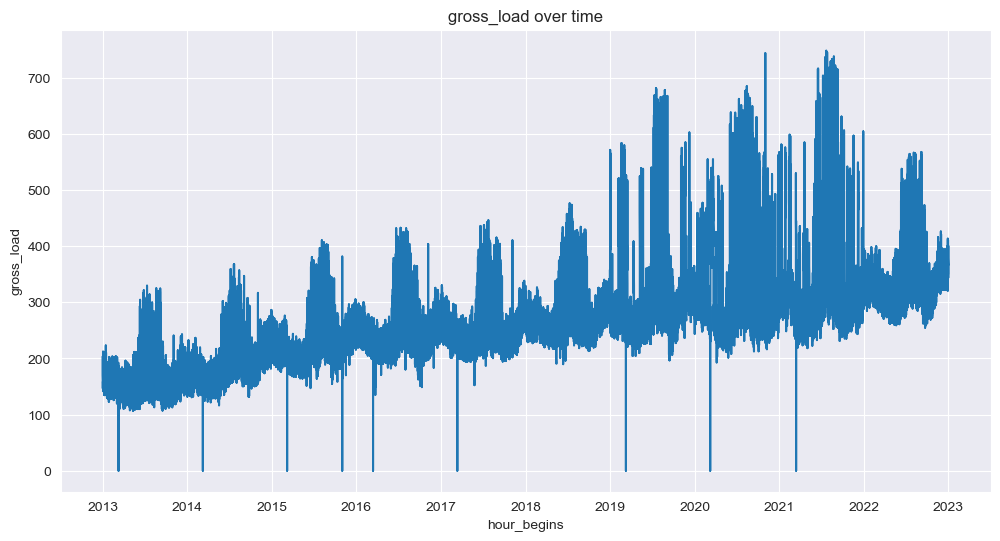

In [572]:
import matplotlib.pyplot as plt

# basic plots for actual_gross_load with x being hour_begins
plt.figure(figsize=(12, 6))
plt.plot(df['hour_begins'], df['gross_load'])
plt.title('gross_load over time')
plt.xlabel('hour_begins')
plt.ylabel('gross_load')
plt.show()

In [573]:
# Count the number of hours per day
df['date_begins'] = df['hour_begins'].dt.date
count_per_day = df.groupby('date_begins').size().reset_index(name='counts')

# Filter dates with less than 24 hours of data
incomplete_days = count_per_day[count_per_day['counts'] < 24]['date_begins']
print(f'Length of incomplete days: {len(incomplete_days)}')
print("Incomplete days (less than 24 hours of data):")
for day in incomplete_days:
    print(day)
# Remove rows with incomplete days
df_filtered = df[~df['date_begins'].isin(incomplete_days)]
df_filtered

Length of incomplete days: 1
Incomplete days (less than 24 hours of data):
2013-01-01


,year,month,day,time,gross_load,hour_begins,ratio,date_begins
23,2013,1,2,00:00:00,155.906000,2013-01-02,NaN,2013-01-02
24,2013,1,2,01:00:00,147.791000,2013-01-02,NaN,2013-01-02
25,2013,1,2,02:00:00,143.175000,2013-01-02,NaN,2013-01-02
26,2013,1,2,03:00:00,141.787000,2013-01-02,NaN,2013-01-02
27,2013,1,2,04:00:00,143.601000,2013-01-02,NaN,2013-01-02
...,...,...,...,...,...,...,...,...
87642,2022,12,31,19:00:00,398.300968,2022-12-31,0.964262,2022-12-31
87643,2022,12,31,20:00:00,390.075813,2022-12-31,0.964262,2022-12-31
87644,2022,12,31,21:00:00,381.049356,2022-12-31,0.964262,2022-12-31
87645,2022,12,31,22:00:00,373.566682,2022-12-31,0.964262,2022-12-31


In [574]:
# calculate the daily accumulation of the load (gross_load_replaced)
daily_accumulation = df.groupby('date_begins')['gross_load'].sum().reset_index()
daily_accumulation.rename(columns = {'gross_load': 'daily_accumulation'}, inplace = True)
daily_accumulation

,date_begins,daily_accumulation
0,2013-01-01,3817.517000
1,2013-01-02,4160.367000
2,2013-01-03,4167.364000
3,2013-01-04,4056.047000
4,2013-01-05,3877.784000
...,...,...
3647,2022-12-27,8492.248001
3648,2022-12-28,8511.042432
3649,2022-12-29,8794.313689
3650,2022-12-30,8993.069308


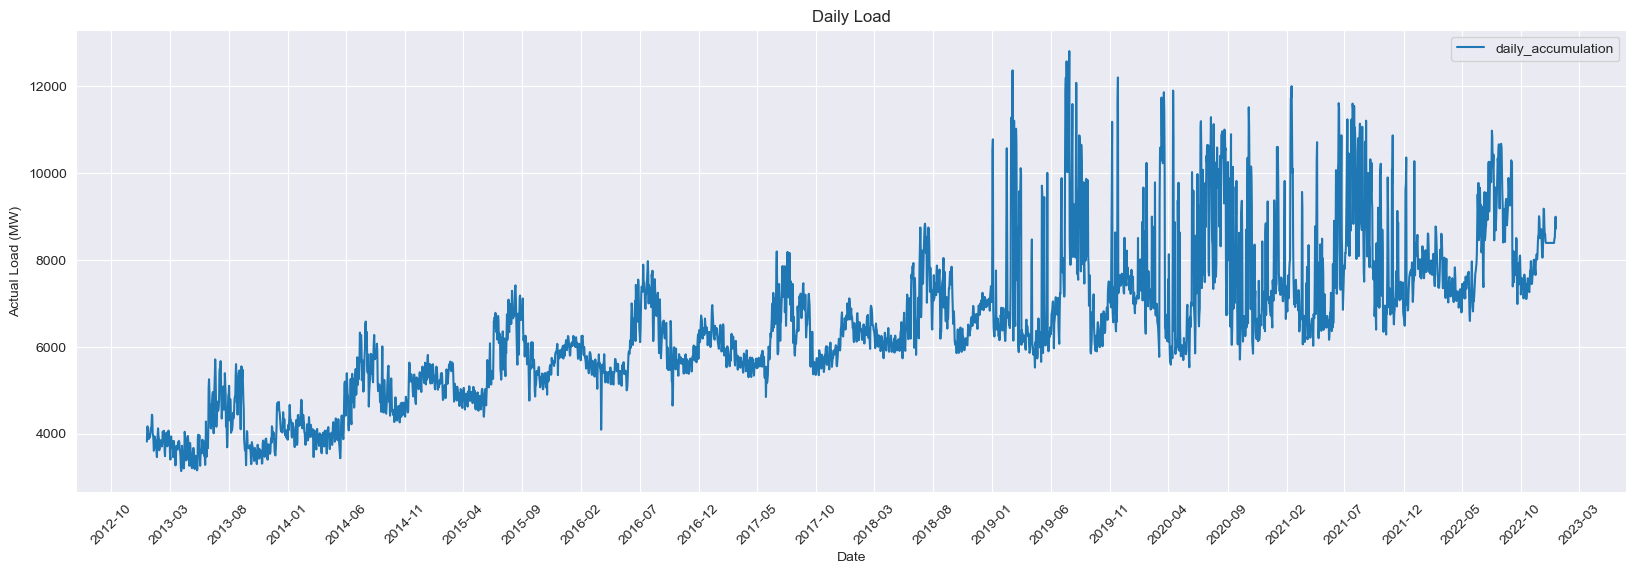

In [575]:
import matplotlib.dates as mdates
# plot the daily average, min, max, std
plt.figure(figsize=(20, 6))
plt.plot(daily_accumulation['date_begins'], daily_accumulation['daily_accumulation'], label='daily_accumulation')
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.title('Daily Load')
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))  # set to show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of outliers: 0


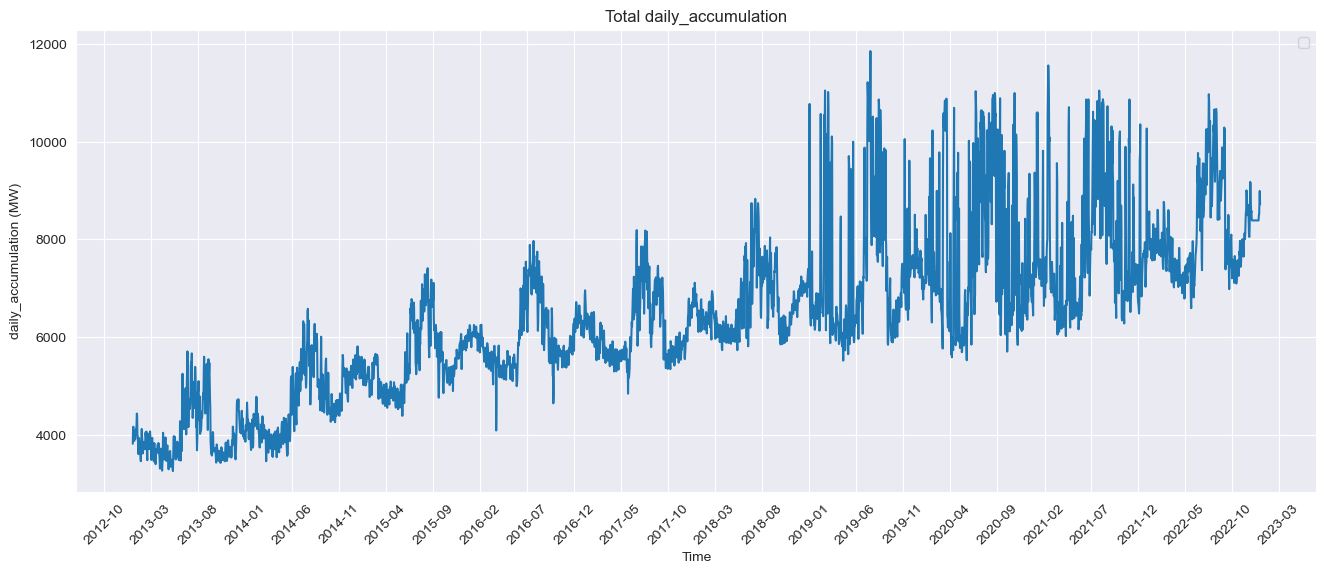

In [576]:
# replace the outlier values as the average of the previous day and the next day
def replace_outliers_with_avg(s):
    lower_bound = s.quantile(0.01)
    upper_bound = s.quantile(0.99)
    outliers = (s < lower_bound) | (s > upper_bound)
    
    for idx in s[outliers].index:
        if idx == 0 or idx == len(s) - 1:
            # directly drop the first and last value
            s.at[idx] = np.nan
            continue
        prev_val = s.iloc[idx - 1]
        next_val = s.iloc[idx + 1]
        s.at[idx] = (prev_val + next_val) / 2
    return s

# reset index 
daily_accumulation.reset_index(drop=True, inplace=True)
# Assuming df is your DataFrame and 'hour_begins' and 'gross_load' are the relevant columns
daily_accumulation['daily_accumulation'] = replace_outliers_with_avg(daily_accumulation['daily_accumulation'].copy())

# Number of outliers
print(f'Number of outliers: {daily_accumulation[daily_accumulation["daily_accumulation"] != daily_accumulation["daily_accumulation"]].shape[0]}')

# Plot the replaced 'gross_load_replaced'
plt.figure(figsize=(16, 6))
plt.plot(daily_accumulation['date_begins'], daily_accumulation['daily_accumulation'])
plt.xlabel('Time')
plt.ylabel('daily_accumulation (MW)')
plt.title('Total daily_accumulation')
plt.legend()
# Set date format on x-axis every 5 month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

## 2.2. feature engineering

In [577]:
# day of the week, month, year, season vairables
daily_accumulation['date_begins'] = pd.to_datetime(daily_accumulation['date_begins'])
daily_accumulation['day_of_week'] = daily_accumulation['date_begins'].dt.dayofweek
daily_accumulation['month'] = daily_accumulation['date_begins'].dt.month
daily_accumulation['year'] = daily_accumulation['date_begins'].dt.year
daily_accumulation['seasons'] = (daily_accumulation['month']%12 + 3)//3
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
daily_accumulation['seasons'] = daily_accumulation['seasons'].map(seasons)

In [578]:
daily_accumulation['month_sin'] = np.sin((daily_accumulation['month'] - 1) * (2. * np.pi / 12))
daily_accumulation['month_cos'] = np.cos((daily_accumulation['month'] - 1) * (2. * np.pi / 12))
daily_accumulation['dow_sin'] = np.sin(daily_accumulation['day_of_week'] * (2. * np.pi / 7))
daily_accumulation['dow_cos'] = np.cos(daily_accumulation['day_of_week'] * (2. * np.pi / 7))

In [579]:
# holiday - 0/1 binary
us_holidays = holidays.US()
daily_accumulation['holiday'] = daily_accumulation['date_begins'].apply(lambda x: 1 if x in us_holidays else 0)

In [580]:
daily_accumulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date_begins         3652 non-null   datetime64[ns]
 1   daily_accumulation  3652 non-null   float64       
 2   day_of_week         3652 non-null   int32         
 3   month               3652 non-null   int32         
 4   year                3652 non-null   int32         
 5   seasons             3652 non-null   object        
 6   month_sin           3652 non-null   float64       
 7   month_cos           3652 non-null   float64       
 8   dow_sin             3652 non-null   float64       
 9   dow_cos             3652 non-null   float64       
 10  holiday             3652 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int32(3), int64(1), object(1)
memory usage: 271.2+ KB


In [581]:
daily_accumulation

,date_begins,daily_accumulation,day_of_week,month,year,seasons,month_sin,month_cos,dow_sin,dow_cos,holiday
0,2013-01-01,3817.517000,1,1,2013,Winter,0.0,1.000000,0.781831,0.623490,1
1,2013-01-02,4160.367000,2,1,2013,Winter,0.0,1.000000,0.974928,-0.222521,0
2,2013-01-03,4167.364000,3,1,2013,Winter,0.0,1.000000,0.433884,-0.900969,0
3,2013-01-04,4056.047000,4,1,2013,Winter,0.0,1.000000,-0.433884,-0.900969,0
4,2013-01-05,3877.784000,5,1,2013,Winter,0.0,1.000000,-0.974928,-0.222521,0
...,...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-27,8492.248001,1,12,2022,Winter,-0.5,0.866025,0.781831,0.623490,0
3648,2022-12-28,8511.042432,2,12,2022,Winter,-0.5,0.866025,0.974928,-0.222521,0
3649,2022-12-29,8794.313689,3,12,2022,Winter,-0.5,0.866025,0.433884,-0.900969,0
3650,2022-12-30,8993.069308,4,12,2022,Winter,-0.5,0.866025,-0.433884,-0.900969,0


In [582]:
# print out the numerical and categorical features
numerical_features = daily_accumulation.select_dtypes(include=['float64']).columns.tolist()
categorical_features = daily_accumulation.select_dtypes(include=['datetime64[ns]', 'object', 'bool','int32','int64']).columns.tolist()
target = 'daily_accumulation'
numerical_features.remove(target)
print(f'Target variable: {target}')
print(f'Numerical features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

# put categorical features first, numerical features last
daily_accumulation = daily_accumulation[categorical_features + numerical_features + [target]]
daily_accumulation

Target variable: daily_accumulation
Numerical features: ['month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Categorical features: ['date_begins', 'day_of_week', 'month', 'year', 'seasons', 'holiday']


,date_begins,day_of_week,month,year,seasons,holiday,month_sin,month_cos,dow_sin,dow_cos,daily_accumulation
0,2013-01-01,1,1,2013,Winter,1,0.0,1.000000,0.781831,0.623490,3817.517000
1,2013-01-02,2,1,2013,Winter,0,0.0,1.000000,0.974928,-0.222521,4160.367000
2,2013-01-03,3,1,2013,Winter,0,0.0,1.000000,0.433884,-0.900969,4167.364000
3,2013-01-04,4,1,2013,Winter,0,0.0,1.000000,-0.433884,-0.900969,4056.047000
4,2013-01-05,5,1,2013,Winter,0,0.0,1.000000,-0.974928,-0.222521,3877.784000
...,...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-27,1,12,2022,Winter,0,-0.5,0.866025,0.781831,0.623490,8492.248001
3648,2022-12-28,2,12,2022,Winter,0,-0.5,0.866025,0.974928,-0.222521,8511.042432
3649,2022-12-29,3,12,2022,Winter,0,-0.5,0.866025,0.433884,-0.900969,8794.313689
3650,2022-12-30,4,12,2022,Winter,0,-0.5,0.866025,-0.433884,-0.900969,8993.069308


In [583]:
daily_accumulation.columns

Index(['date_begins', 'day_of_week', 'month', 'year', 'seasons', 'holiday',
       'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'daily_accumulation'],
      dtype='object')

##  2.3. scaling and encoding

In [584]:
# encoding the categorical features - season only at the second column of values
daily_accumulation = pd.get_dummies(daily_accumulation, columns=['seasons'], drop_first=True) # at the last 3 columns
# Convert boolean columns to integers
for col in daily_accumulation.columns:
    if daily_accumulation[col].dtype == 'bool':
        daily_accumulation[col] = daily_accumulation[col].astype(int)
# place the target variable at the last column
daily_accumulation = daily_accumulation[[c for c in daily_accumulation if c not in ['daily_accumulation']] + ['daily_accumulation']]

In [585]:
# scaling the columns except for the 1 column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_accumulation.iloc[:, 1:] = scaler.fit_transform(daily_accumulation.iloc[:, 1:])
daily_accumulation

,date_begins,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_accumulation
0,2013-01-01,0.166667,0.0,0.0,1,0.50,1.000000,0.900969,8.019377e-01,0,0,1,0.064964
1,2013-01-02,0.333333,0.0,0.0,0,0.50,1.000000,1.000000,3.568959e-01,0,0,1,0.104842
2,2013-01-03,0.500000,0.0,0.0,0,0.50,1.000000,0.722521,5.551115e-17,0,0,1,0.105656
3,2013-01-04,0.666667,0.0,0.0,0,0.50,1.000000,0.277479,0.000000e+00,0,0,1,0.092708
4,2013-01-05,0.833333,0.0,0.0,0,0.50,1.000000,0.000000,3.568959e-01,0,0,1,0.071974
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-27,0.166667,1.0,1.0,0,0.25,0.933013,0.900969,8.019377e-01,0,0,1,0.608699
3648,2022-12-28,0.333333,1.0,1.0,0,0.25,0.933013,1.000000,3.568959e-01,0,0,1,0.610885
3649,2022-12-29,0.500000,1.0,1.0,0,0.25,0.933013,0.722521,5.551115e-17,0,0,1,0.643833
3650,2022-12-30,0.666667,1.0,1.0,0,0.25,0.933013,0.277479,0.000000e+00,0,0,1,0.666951


In [586]:
# save the values of column gross_load_replaced, drop it and the attach at the last column 
gross_load_replaced = daily_accumulation['daily_accumulation']
daily_accumulation.drop(columns='daily_accumulation', inplace=True)
daily_accumulation['daily_accumulation'] = gross_load_replaced
daily_accumulation

,date_begins,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_accumulation
0,2013-01-01,0.166667,0.0,0.0,1,0.50,1.000000,0.900969,8.019377e-01,0,0,1,0.064964
1,2013-01-02,0.333333,0.0,0.0,0,0.50,1.000000,1.000000,3.568959e-01,0,0,1,0.104842
2,2013-01-03,0.500000,0.0,0.0,0,0.50,1.000000,0.722521,5.551115e-17,0,0,1,0.105656
3,2013-01-04,0.666667,0.0,0.0,0,0.50,1.000000,0.277479,0.000000e+00,0,0,1,0.092708
4,2013-01-05,0.833333,0.0,0.0,0,0.50,1.000000,0.000000,3.568959e-01,0,0,1,0.071974
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-27,0.166667,1.0,1.0,0,0.25,0.933013,0.900969,8.019377e-01,0,0,1,0.608699
3648,2022-12-28,0.333333,1.0,1.0,0,0.25,0.933013,1.000000,3.568959e-01,0,0,1,0.610885
3649,2022-12-29,0.500000,1.0,1.0,0,0.25,0.933013,0.722521,5.551115e-17,0,0,1,0.643833
3650,2022-12-30,0.666667,1.0,1.0,0,0.25,0.933013,0.277479,0.000000e+00,0,0,1,0.666951


In [587]:
daily_accumulation = daily_accumulation.dropna()
daily_accumulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date_begins         3652 non-null   datetime64[ns]
 1   day_of_week         3652 non-null   float64       
 2   month               3652 non-null   float64       
 3   year                3652 non-null   float64       
 4   holiday             3652 non-null   int64         
 5   month_sin           3652 non-null   float64       
 6   month_cos           3652 non-null   float64       
 7   dow_sin             3652 non-null   float64       
 8   dow_cos             3652 non-null   float64       
 9   seasons_Spring      3652 non-null   int32         
 10  seasons_Summer      3652 non-null   int32         
 11  seasons_Winter      3652 non-null   int32         
 12  daily_accumulation  3652 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int32(3), int6

## 2.4. dividing the data into training and testing

In [588]:
years_of_data = len(daily_accumulation) / 365
print(f'Total years of data: {years_of_data}')
# total number of days for training and testing
print(f'Total number of days for training: {daily_accumulation.shape[0]}')

Total years of data: 10.005479452054795
Total number of days for training: 3652


In [589]:
daily_accumulation = daily_accumulation.sort_values(by='date_begins')
values = daily_accumulation.drop(columns='date_begins').values
dates = daily_accumulation['date_begins']

# out of sample data: total length multiplies 0.3
train_days = int(values.shape[0] * 0.7)
# in sample data: the rest of the data
train = values[:train_days, :]
train_timestamps = dates[:train_days]
# print(f'start date of in sample data: {train["date"].min()}')
# print(f'end date of in sample data: {train["date"].max()}')
# print(f'length of in sample data: {train.
# shape[0]}\n')

print(f'min: {train_timestamps.min()}')
print(f'max: {train_timestamps.max()}')
print(f'length of in sample data: {train.shape[0]}\n')

test = values[train_days:, : ]
test_timestamps = dates[train_days:]
# print(f'start date of out of sample data: {test["date"].min()}')
# print(f'end date of out of sample data: {test["date"].max()}')
# print(f'length of out of sample data: {test.shape[0]}\n')

print(f'min: {test_timestamps.min()}')
print(f'max: {test_timestamps.max()}')
print(f'length of out of sample data: {test.shape[0]}')

min: 2013-01-01 00:00:00
max: 2019-12-31 00:00:00
length of in sample data: 2556

min: 2020-01-01 00:00:00
max: 2022-12-31 00:00:00
length of out of sample data: 1096


In [590]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2556, 1, 11) (2556,) (1096, 1, 11) (1096,)


## 2.5. fitting the model

In [629]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
# design network

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.4))
model.add(Dense(1, kernel_regularizer=l2(0.001)))

# Set the initial learning rate to a lower value
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6)

# Fit the network
history = model.fit(train_X, train_y, epochs=300, batch_size=80, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

Epoch 1/300
32/32 - 1s - 43ms/step - loss: 0.3085 - mae: 0.3068 - mape: 12031.8057 - mse: 0.1191 - val_loss: 0.5428 - val_mae: 0.5412 - val_mape: 98.1734 - val_mse: 0.3187 - learning_rate: 1.0000e-04
Epoch 2/300
32/32 - 0s - 2ms/step - loss: 0.2763 - mae: 0.2747 - mape: 6884.2480 - mse: 0.1003 - val_loss: 0.5052 - val_mae: 0.5036 - val_mape: 90.7441 - val_mse: 0.2797 - learning_rate: 1.0000e-04
Epoch 3/300
32/32 - 0s - 1ms/step - loss: 0.2452 - mae: 0.2436 - mape: 43539.6406 - mse: 0.0823 - val_loss: 0.4694 - val_mae: 0.4678 - val_mape: 83.6885 - val_mse: 0.2452 - learning_rate: 1.0000e-04
Epoch 4/300
32/32 - 0s - 1ms/step - loss: 0.2208 - mae: 0.2192 - mape: 57179.6445 - mse: 0.0691 - val_loss: 0.4361 - val_mae: 0.4345 - val_mape: 77.1168 - val_mse: 0.2152 - learning_rate: 1.0000e-04
Epoch 5/300
32/32 - 0s - 1ms/step - loss: 0.1975 - mae: 0.1959 - mape: 29277.8965 - mse: 0.0572 - val_loss: 0.4049 - val_mae: 0.4033 - val_mape: 70.9799 - val_mse: 0.1892 - learning_rate: 1.0000e-04
Epoch

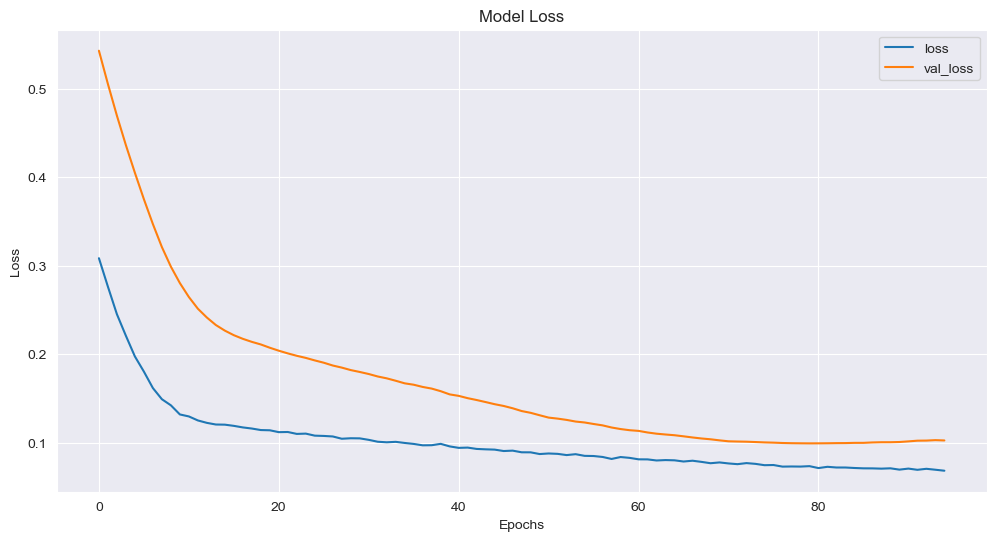

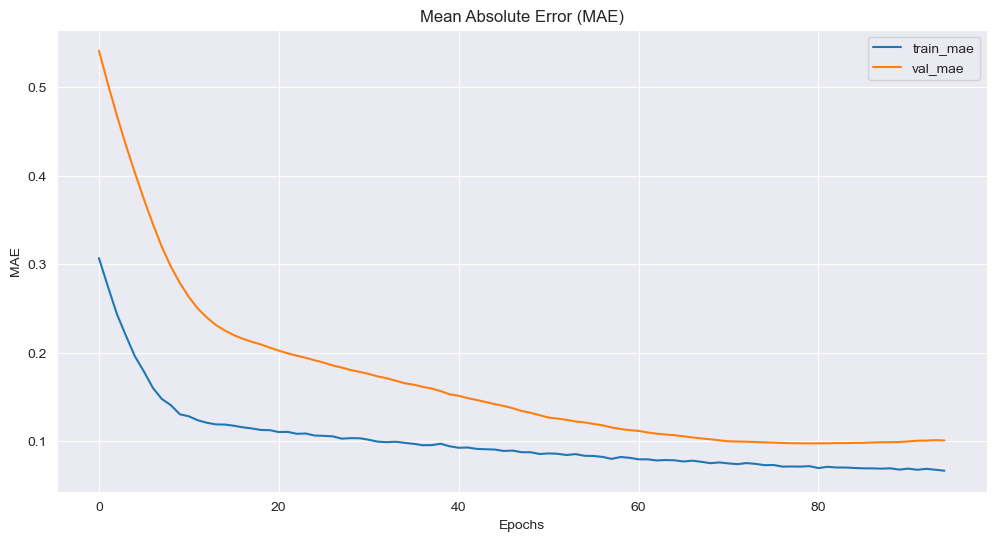

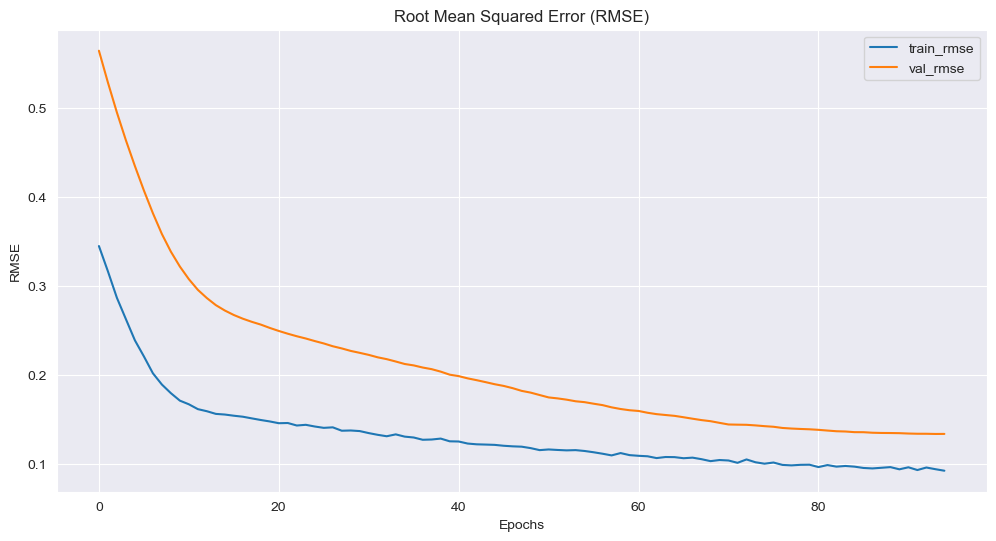

In [630]:
# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [631]:
# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((train_X_reshaped,train_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
train_y_reshaped = train_y.reshape((len(train_y), 1))
inv_y = np.concatenate((train_X_reshaped, train_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
train_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
train_mae = mean_absolute_error(inv_y, inv_yhat)
train_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


test_predictions = model.predict(test_X)
# Reshape test_X for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((test_X_reshaped,test_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X_reshaped, test_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
test_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
test_mae = mean_absolute_error(inv_y, inv_yhat)
test_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Train MAPE: {train_mape:.3f}%")
print(f"\nTest RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test MAPE: {test_mape:.3f}%")

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
Train RMSE: 726.929
Train MAE: 493.044
Train MAPE: 8.577%

Test RMSE: 1196.797
Test MAE: 837.984
Test MAPE: 9.769%


## 2.6. prediction plot

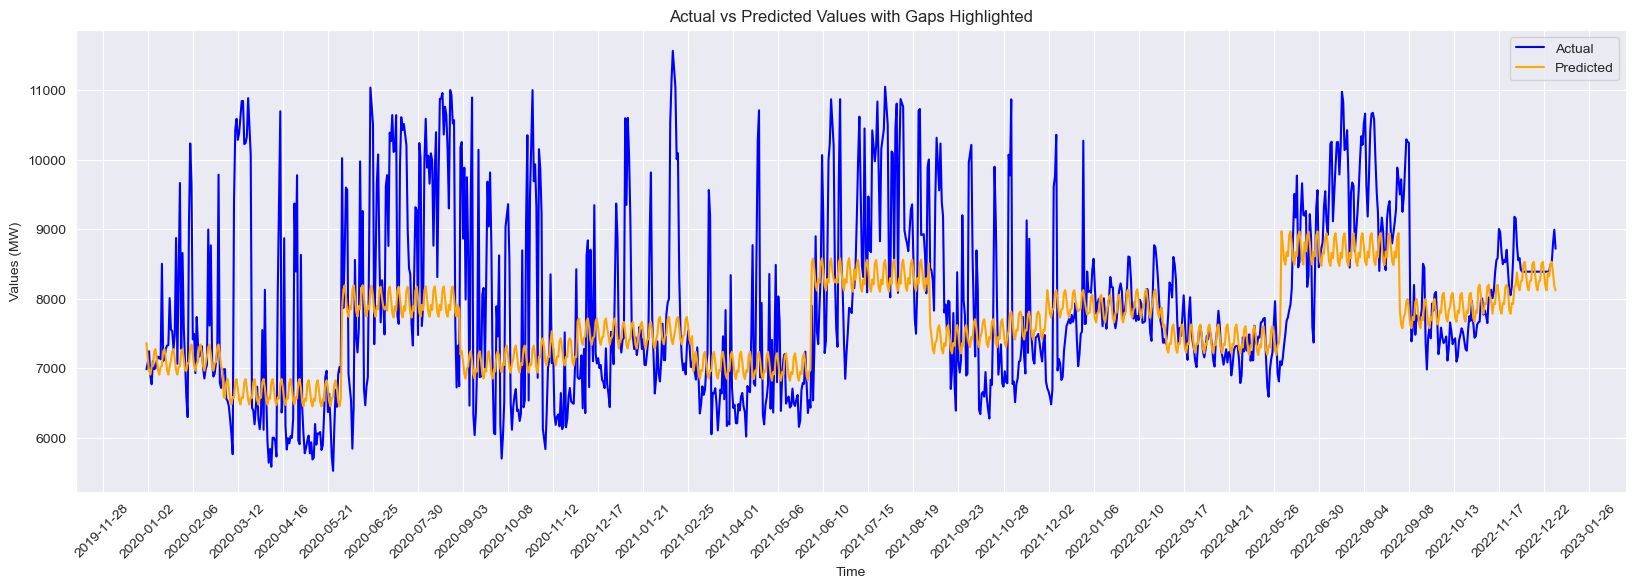

Gaps in data:


In [632]:
# Extract the test data with timestamps
test_df = daily_gross_load.iloc[train_days:, :].copy()
test_df['date'] = daily_gross_load.iloc[train_days:]['date']

# Identify gaps in the data
actual_vs_predicted = pd.DataFrame({
    'date': test_timestamps,
    'actual': inv_y,
    'predicted': inv_yhat
})

# Check for gaps in the timestamps (in days)
actual_vs_predicted['date_diff'] = actual_vs_predicted['date'].diff().dt.days
gaps = actual_vs_predicted[actual_vs_predicted['date_diff'] > 1]

# Plot actual vs predicted values with gaps highlighted
plt.figure(figsize=(20, 6))
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['actual'], label='Actual', color='blue')
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['predicted'], label='Predicted', color='orange')
for gap_start in gaps['date']:
    plt.axvline(x=gap_start, color='red', linestyle='--', alpha=0.5)
plt.title('Actual vs Predicted Values with Gaps Highlighted')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)

# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=35))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()

# Print the gaps and their nearest significant time differences
print("Gaps in data:")
for index, row in gaps.iterrows():
    previous_timestamp = row['date'] - pd.Timedelta(days=row['date_diff'])
    next_timestamp = row['date'] + pd.Timedelta(days=row['date_diff'])

    previous_row = actual_vs_predicted[actual_vs_predicted['date'] == previous_timestamp]
    next_row = actual_vs_predicted[actual_vs_predicted['date'] == next_timestamp]

    gap_start = previous_row['date'].values[0] if not previous_row.empty else 'N/A'
    gap_end = row['date']

    print(f"Gap Start: {pd.to_datetime(gap_start).strftime('%Y-%m-%d') if gap_start != 'N/A' else 'N/A'}")
    print(f"Gap ends at: {gap_end.strftime('%Y-%m-%d')}")
    print(f"Time Difference: {row['date_diff']} days\n")